# Bayesian Neural Network MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of an MCMC algorithm applied to a Neural Network.

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
os.chdir('/project')

In [6]:
import os
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed, widgets
from tqdm import tqdm
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_y_timeseries, 
    plot_ycorr_scatter, boxplot_weights,
    plot_linear_data
)

from types import MethodType

np.random.seed(2023)

## Define a class with the functions and attributes required for a neural network model


In [7]:
from models.bnn_model import NeuralNetwork
from models.mcmc import MCMC_BNN as MCMC

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [8]:
# load the data
name        = "Iris" # "Sunspot", "Abalone"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (105, 5)
Test data shape: (45, 5)


## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [11]:
# GR
# n_samples = 100000 # number of samples to draw from the posterior
# burn_in = 50000 # number of samples to discard before recording draws from the posterior

# thin_factor = 10

# single trace
n_samples = 500000 # number of samples to draw from the posterior
burn_in = 100000 # number of samples to discard before recording draws from the posterior
hidden = 10
learning_rate = 0.01
thin_factor = 50

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

if name in ['Sunspot','Abalone']:
    layer_sizes = [x_data.shape[1], hidden, 1]
    data_case = 'regression'
elif name in ['Iris']:
    layer_sizes = [x_data.shape[1], hidden, 3]
    data_case = 'classification'
elif name in ['Ionosphere']:
    layer_sizes = [x_data.shape[1], hidden, 2]
    data_case = 'classification'
else:
    raise ValueError('data_case is invalid.')

thinned_res = []

## MCMC Settings and Setup
for this_chain in np.arange(1):
    print('Chain: {}'.format(this_chain))
    np.random.seed(2023 + this_chain)
    # Initialise the MCMC class
    bnnm = NeuralNetwork(layer_sizes=layer_sizes,data_case=data_case)
    mcmc = MCMC(bnnm,n_samples, burn_in, x_data, y_data, x_test, y_test)
    # Run the sampler
    results, pred = mcmc.sampler()
    # thin to remove autocorrelation and to reduce the size of the data 
    results = results.iloc[::thin_factor,:]
    for _ in pred.keys():
        pred[_] = pred[_][::thin_factor,:]

    thinned_res.append(results)

Chain: 0


100%|██████████| 499999/499999 [1:58:33<00:00, 70.29it/s]  


97.6% was accepted


In [12]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

In [13]:
thinned_res[0].shape

conc_res = np.stack(thinned_res,axis=0)
# results = pd.concat(thinned_res, axis=0)

In [ ]:
print(conc_res.shape)

from convergence.convergence import gelman_rubin
# run gelman rubin test
gr = gelman_rubin(conc_res)

# print the results into pandas then print
gr_df = pd.DataFrame(data = gr, index=thinned_res[0].columns).T
gr_df.index = ['Rhat']
gr_df

## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

In [14]:
# Print the train/test RMSE
trainRMSE = np.array([mcmc.rmse(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testRMSE = np.array([mcmc.rmse(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train RMSE: {:.5f} ({:.5f})'.format(trainRMSE.mean(),trainRMSE.std()))
print('Test RMSE: {:.5f} ({:.5f})'.format(testRMSE.mean(),testRMSE.std()))

Train RMSE: 0.05437 (0.05006)
Test RMSE: 0.07771 (0.08430)


In [15]:
def plot_hist(results, param_name):
    # results = results_rmse
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

<function __main__.plot_hist(results, param_name)>

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
sns.set_style('ticks')

# Now plot posterior distribution and trace plot for selected parameters
def plot_posterior(this_model, this_data, this_param, save_dir=None):
    '''
    Plot the posterior as a histogram and then the traceplot
    '''
    plot_data = results[this_param]
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # plot the posterior distribution
    sns.histplot(plot_data.values, ax=ax, bins=20, edgecolor='xkcd:dark grey', linewidth=1.5)
    ax.set_xlabel('Parameter Value', labelpad=10)
    ax.set_ylabel('Frequency', labelpad=10)
    ax.set_title('Posterior distribution', pad=10)
    fig.tight_layout()
    
    # plot the trace plot
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    sns.lineplot(x=np.arange(plot_data.shape[0]),y=plot_data.values,ax=ax1)
    ax1.set_xlabel('Samples', labelpad=10)
    ax1.set_ylabel('Parameter Value', labelpad=10)
    ax1.set_title('Trace plot', pad=10)

    fig1.tight_layout()
    
    if not save_dir is None:
        fig.savefig(os.path.join(save_dir,'{}_{}_{}_posterior.png'.format(this_model,this_data,this_param)))
        fig1.savefig(os.path.join(save_dir,'{}_{}_{}_trace.png'.format(this_model,this_data,this_param)))


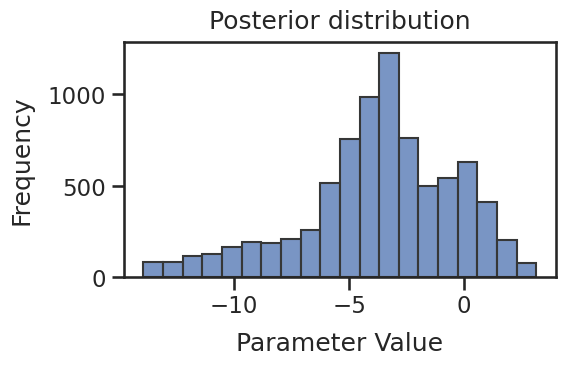

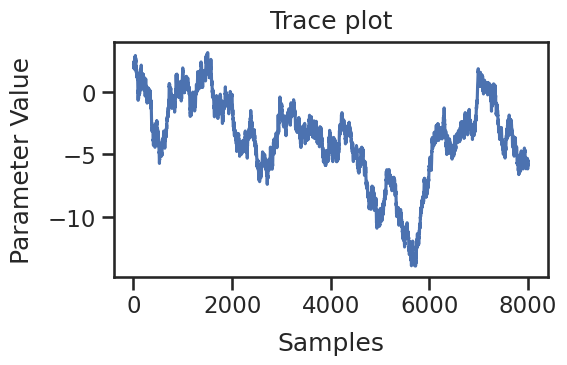

In [30]:
results_dir = os.path.join('publication_results','results')
fig_dir = os.path.join(
    results_dir,
    'figures',
    'posterior'
)
os.makedirs(fig_dir, exist_ok=True)

plot_posterior('bnn_tp',name,'w0',save_dir=fig_dir)